In [1]:
# imports 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
import tensorflow as tf
from tensorflow import keras

In [2]:
# prepration
SAMPLE =1000
f_1 =np.random.randint(30 ,40 ,SAMPLE).reshape(-1,1)
f_2 =np.random.rand(SAMPLE).reshape(-1,1)
f_3 =np.random.randint(1,3 ,SAMPLE).reshape(-1,1)
x =np.concatenate((f_1 ,f_2 ,f_3) ,axis =1).astype(np.float32)
x_norm =x /np.max(x ,axis =0)
y =((1/5 *x_norm[:,0]) + (2/5 *x_norm[:,1]) + (2/5 *x_norm[:,2])).reshape(-1,1)
noise =np.random.normal(loc =0 ,scale =0.05 ,size =SAMPLE).reshape(-1,1).astype(np.float32)
y_noise =y +noise
xtr ,xte ,ytr ,yte =train_test_split(x_norm ,y_noise ,test_size =0.2)
x_fram =pd.DataFrame(x_norm ,columns =['f_1' ,'f_2' ,'f_3'])
print(x_fram.describe(percentiles =[0.3 ,0.6 ,0.9]))

In [23]:
# model definition
class LinearModel(keras.Model) : 
    def __init__(self) : 
        super().__init__()
        self.layer1 =keras.layers.Dense(units =1024) 
        self.norm1 =keras.layers.BatchNormalization()
        self.act1 =keras.layers.ReLU()
        self.drop1 =keras.layers.Dropout(rate =0.2)
        self.layer2 =keras.layers.Dense(units =512) 
        self.norm2 =keras.layers.BatchNormalization()
        self.act2 =keras.layers.ReLU()
        self.drop2 =keras.layers.Dropout(rate =0.2)
        self.layer3 =keras.layers.Dense(units =256) 
        self.norm3 =keras.layers.BatchNormalization()
        self.act3 =keras.layers.ReLU()
        self.drop3 =keras.layers.Dropout(rate =0.2)
        self.layer4 =keras.layers.Dense(units =128) 
        self.norm4 =keras.layers.BatchNormalization()
        self.act4 =keras.layers.ReLU()
        self.drop4 =keras.layers.Dropout(rate =0.2)
        self.layer5 =keras.layers.Dense(units =64) 
        self.norm5 =keras.layers.BatchNormalization()
        self.act5 =keras.layers.ReLU()
        self.drop5 =keras.layers.Dropout(rate =0.2)
        self.layer6 =keras.layers.Dense(units =32) 
        self.norm6 =keras.layers.BatchNormalization()
        self.act6 =keras.layers.ReLU()
        self.drop6 =keras.layers.Dropout(rate =0.2)
        self.layer7 =keras.layers.Dense(units =1) 
        self.norm7 =keras.layers.BatchNormalization()
        self.act7 =keras.layers.Activation(keras.activations.linear)
    def call(self ,inputs ,training =True) : 
        i =self.layer1(inputs)
        o =self.act7(i ,training =training)
        return self.layer7(o)
model =LinearModel()
model.compile(optimizer =keras.optimizers.RMSprop(learning_rate=0.001) ,
              loss ='mean_squared_error' ,
              metrics =['r2_score' ,
                        'mean_absolute_error'])

In [3]:
# cross validation
SPLIT =4 
REPEAT =2
rkf =RepeatedKFold(n_splits =SPLIT ,n_repeats =REPEAT) 
r2_total_fold =[]
mae_total_fold =[]
for idx_tr ,idx_val in rkf.split(xtr ,ytr) : 
    xtr_fold =xtr[idx_tr] 
    ytr_fold =ytr[idx_tr] 
    xval_fold =xtr[idx_val] 
    yval_fold =ytr[idx_val]
    model.fit(xtr_fold ,
              ytr_fold ,
              batch_size =32 ,
              validation_batch_size=16 ,
              validation_data =(xval_fold ,yval_fold) ,
              epochs =100 ,
              verbose =2
              )
    eva_fold =model.evaluate(xval_fold ,yval_fold ,verbose =0 ,return_dict =True) 
    r2_total_fold.append(eva_fold['r2_score'])
    mae_total_fold.append(eva_fold['mean_absolute_error'])
r2_mean_fold =np.mean(r2_total_fold) 
mae_mean_fold =np.mean(mae_total_fold) 
print(f'r2_score_mean_for_k_fold/n_repeat : {r2_mean_fold}' ,'\n')
print(f'mae_mean_for_k_fold/n_repeat : {mae_mean_fold}')

In [4]:
# model training
EPOCH =200
BATCH =32
VAL_BATCH =16
save_path ='save_model.keras'
model_checkpoint =keras.callbacks.ModelCheckpoint(filepath =save_path ,
                                                  monitor ='val_loss' ,
                                                  mode ='min' ,
                                                  save_best_only =True)
def Scheduler(epoch ,lr) :
  if epoch < 60 :
    return lr
  else :
    return lr * np.exp(-0.1)
lr_schedule =keras.callbacks.LearningRateScheduler(Scheduler ,verbose =0)
hist =model.fit(xtr ,
                ytr ,
                batch_size =BATCH ,
                epochs =EPOCH ,
                validation_data =(xte ,yte) ,
                validation_batch_size =VAL_BATCH ,
                callbacks=[model_checkpoint ,lr_schedule] ,
                verbose =2)

In [7]:
# model evaluation 
eva_te =model.evaluate(xte ,yte ,batch_size =16 ,verbose =0 ,return_dict =True)
eva_tr =model.evaluate(xtr ,ytr ,batch_size =32 ,verbose =0 ,return_dict =True)
print(f'loss_train_data : {eva_tr['loss']}' ,'\n')
print(f'mae_train_data : {eva_tr['mean_absolute_error']}' ,'\n')
print(f'r2_score_train_data : {eva_tr['r2_score']}' ,'\n')
print(f'loss_test_data : {eva_te['loss']}' ,'\n')
print(f'mae_test_data : {eva_te['mean_absolute_error']}' ,'\n')
print(f'r2_score_test_data : {eva_te['r2_score']}')

loss_train_data : 0.0025733457878232002 

mae_train_data : 0.040614914149045944 

r2_score_train_data : 0.896861732006073 

loss_test_data : 0.0028270867187529802 

mae_test_data : 0.042527589946985245 

r2_score_test_data : 0.8972517251968384


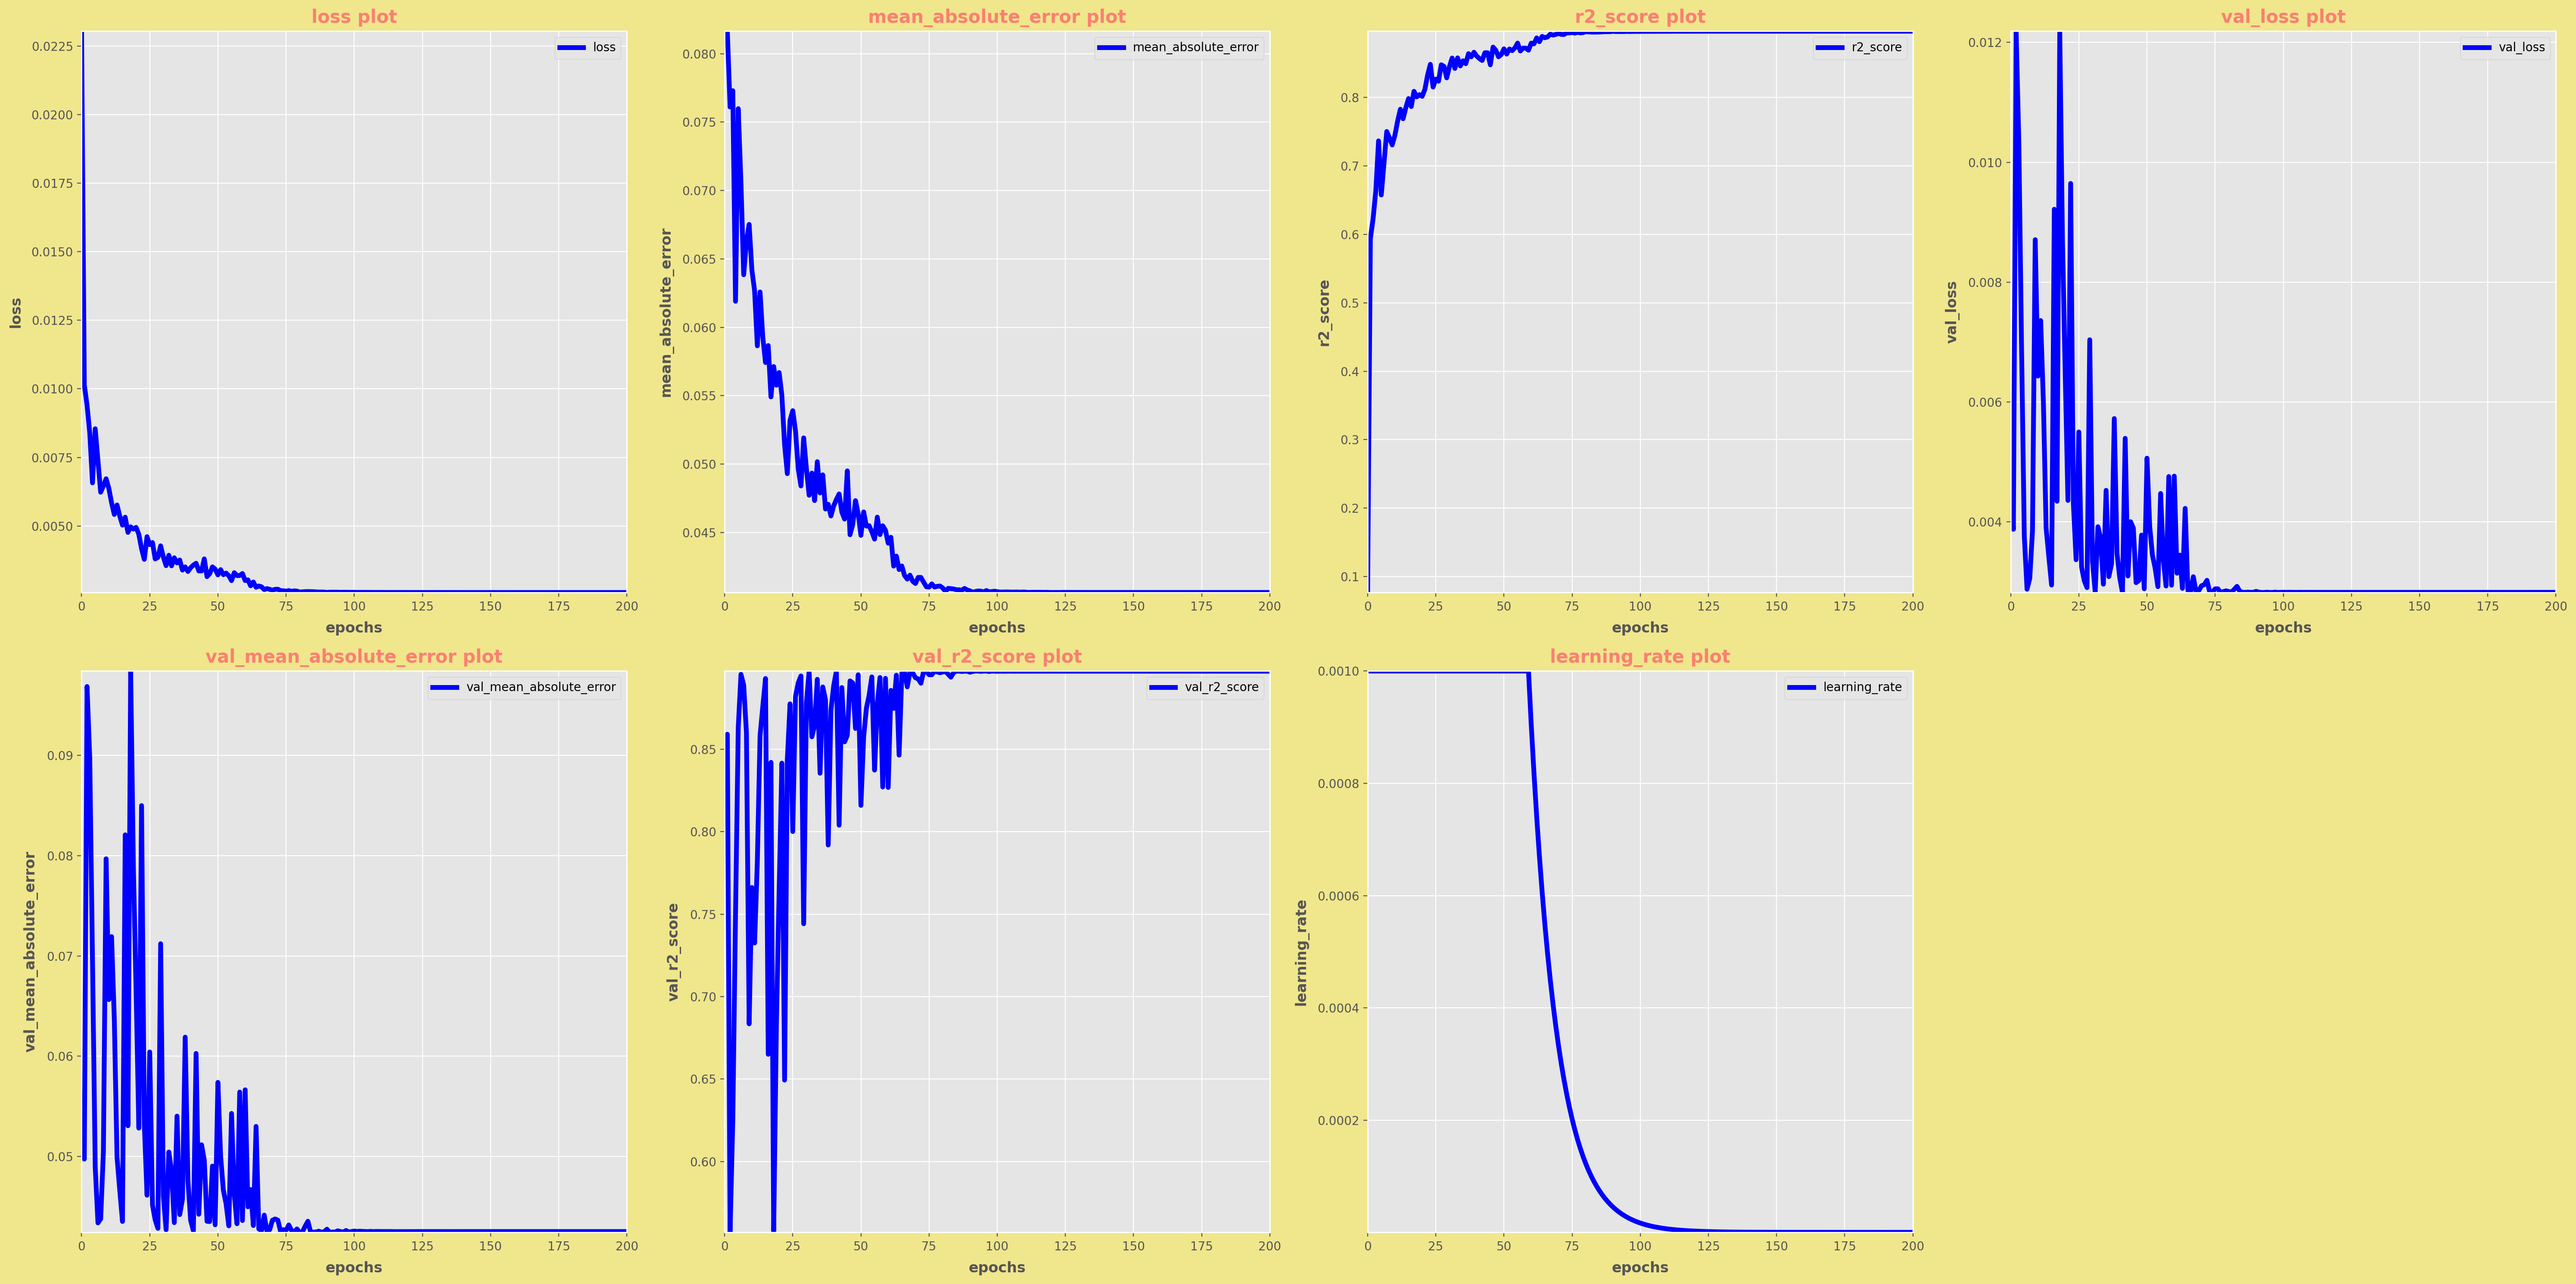

In [25]:
# evaluation plot
pltpath ='plot.jpg'
plt.style.use('ggplot')
plt.figure(num =1 ,figsize =(30,15) ,dpi =200 ,facecolor ='khaki' ,edgecolor='black') 
idx =1
for item in hist.history.keys():
    plt.subplot(2,4,idx)
    plt.plot(hist.history[item] ,ls ='-' ,lw =4 ,color ='blue' ,label =item) 
    plt.xlim((0 ,EPOCH))
    plt.ylim(np.min(hist.history[item]) ,np.max(hist.history[item]))
    plt.xlabel(xlabel ='epochs' ,labelpad =7 ,fontdict={'size' :12 ,'weight' :'bold'})
    plt.ylabel(ylabel =item ,labelpad =7 ,fontdict={'size' :12 ,'weight' :'bold'})
    plt.title(label =f'{item} plot' ,pad =7 ,fontdict={'size' :15 ,'weight' :'bold' ,'color' :'salmon'})
    plt.legend()
    idx +=1
plt.tight_layout()
plt.savefig(pltpath)
plt.show()
